In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import optim, nn
import torch.nn.functional as F 

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import TensorDataset, DataLoader, random_split

In [56]:
torch.manual_seed(0)

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
path = "drive/MyDrive/Colab Notebooks/Datasets/Leather Defect Classification"
train_test_split = 0.2
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((32,32)),
  ])
dataset = ImageFolder(root=path, transform=transform)
size = len(dataset)
test_size = int(train_test_split * size)
train_size = size - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [59]:
batch_size = 40
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [60]:
class LeatherDefectCNN(nn.Module):
  def __init__(self, output_dim):
    super(LeatherDefectCNN, self).__init__()

    self.conv1 = nn.Conv2d(3, 6, 5)
    self.conv2 = nn.Conv2d(6, 16, 5)

    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, output_dim)

    self.dropout = nn.Dropout(0.3)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), 2)
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = torch.flatten(x, 1) 
    x = F.relu(self.fc1(x))
    x = self.dropout(F.relu(self.fc2(x)))
    x = F.softmax(self.fc3(x),dim=1)
    return x              

In [61]:
def calc_accuracy(a, y):                            
  a = torch.max(a, dim=1)[1]
  assert not torch.any(torch.isnan(a))
  return torch.mean((a == y).float()).item()

In [62]:
model = LeatherDefectCNN(6)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [91]:
num_epochs = 25

for epoch in range(num_epochs):
  for image, label in train_loader:
    z = model(image)
    loss = F.cross_entropy(z, label)

    optimizer.zero_grad()      
    loss.backward()
    optimizer.step()

  test_accuracy = 0
  for image, label in test_loader:
    z = model(image)
    accuracy = calc_accuracy(z, label)
    test_accuracy += accuracy / len(test_dataset) * batch_size

  print("Accuracy: {}".format(round(100*test_accuracy, 3)))
    

Accuracy: 49.583
Accuracy: 51.111
Accuracy: 52.222
Accuracy: 50.278
Accuracy: 51.667
Accuracy: 54.444
Accuracy: 52.639
Accuracy: 56.528
Accuracy: 55.694
Accuracy: 53.75
Accuracy: 55.278
Accuracy: 53.611
Accuracy: 56.25
Accuracy: 54.306
Accuracy: 55.139
Accuracy: 55.694
Accuracy: 55.556
Accuracy: 56.25
Accuracy: 57.639
Accuracy: 57.917
Accuracy: 60.417
Accuracy: 53.472
Accuracy: 54.861
Accuracy: 55.833
Accuracy: 58.75


In [92]:
def predict(image):
  return torch.max(model(image.unsqueeze(0)), dim=1)[1].item()

In [93]:
import matplotlib.pyplot as plt

Prediction: 3 | Label: 3


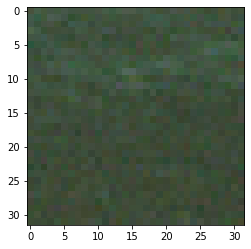

In [94]:
test_item = test_dataset[0]
plt.imshow(test_item[0].permute(1, 2, 0).numpy(), cmap='gray')
print("Prediction:", predict(test_item[0]),"| Label:",test_item[1])

Prediction: 0 | Label: 0


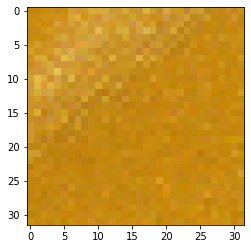

In [95]:
test_item = test_dataset[5]
plt.imshow(test_item[0].permute(1, 2, 0).numpy(), cmap='gray')
print("Prediction:", predict(test_item[0]),"| Label:",test_item[1])

Prediction: 0 | Label: 1


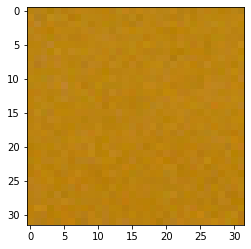

In [96]:
test_item = test_dataset[100]
plt.imshow(test_item[0].permute(1, 2, 0).numpy(), cmap='gray')
print("Prediction:", predict(test_item[0]),"| Label:",test_item[1])

Prediction: 4 | Label: 4


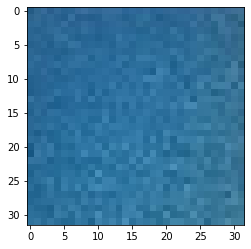

In [97]:
test_item = test_dataset[178]
plt.imshow(test_item[0].permute(1, 2, 0).numpy(), cmap='gray')
print("Prediction:", predict(test_item[0]),"| Label:",test_item[1])

Prediction: 2 | Label: 0


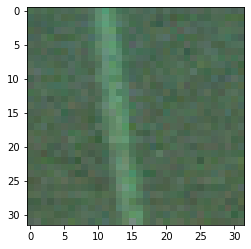

In [98]:
test_item = test_dataset[420]
plt.imshow(test_item[0].permute(1, 2, 0).numpy(), cmap='gray')
print("Prediction:", predict(test_item[0]),"| Label:",test_item[1])

Prediction: 0 | Label: 5


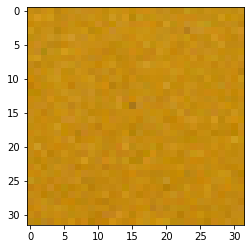

In [99]:
test_item = test_dataset[42]
plt.imshow(test_item[0].permute(1, 2, 0).numpy(), cmap='gray')
print("Prediction:", predict(test_item[0]),"| Label:",test_item[1])